### Part 6 of data cleaning

#### Agenda

1. Load new file without duplicates.  
1. Check size distribution on residential and commercial installations.
1. Remove obvious outliers.

In [1]:
# %load ../pycode/setup.py
# set up
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

def ecdf(data):
    '''Compute ECDF for a one-dimensional array of measurements.'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def min015099max(series, minmax=False):
    ''' return list of [ min, 1%, median, 99%, max ] series values '''
    vals = list(np.percentile(series, [1.0, 50.0, 99.0]))
    if minmax: 
        vals.insert(0, series.min())
        vals.append(series.max())    
    return vals
# ss = np.arange(1, 101)
# min_1_50_99_max(ss)             

def mid98(series):
    '''  return middle 98% of series '''
    bounds = series.quantile([0.01, 0.99])
    return(series[(series > bounds.values[0]) & (series < bounds.values[1])])

# ss = np.arange(1, 101)
# min_1_50_99_max(ss)


In [6]:
# load dataset; force string type for zipcode
#dfLive = pd.read_csv('../local/data/20180108.csv', index_col='date_installed', parse_dates=True, dtype={'zipcode' : np.object})
dfLive = pd.read_csv('../local/data/thing0108', index_col='date_installed', parse_dates=True, dtype={'zipcode' : np.object})

In [7]:
# note that we're down to 650k entries
#                         416k
dfLive.describe()

,row_id,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,416204.000000,416204.000000,4.162040e+05,416204.000000,5038.0,1092.0,112078.0,871.0
mean,389759.045350,5.644024,6.846463e+04,13.516131,1.0,1.0,1.0,1.0
std,218126.031578,2.092055,5.308133e+05,120.615689,0.0,0.0,0.0,0.0
min,1.000000,0.750000,1.000000e+02,0.010000,1.0,1.0,1.0,1.0
25%,194379.500000,4.250000,2.151038e+04,4.080000,1.0,1.0,1.0,1.0
50%,414091.500000,5.250000,3.060000e+04,5.890000,1.0,1.0,1.0,1.0
75%,579745.250000,6.840000,4.412500e+04,8.400000,1.0,1.0,1.0,1.0
max,745361.000000,30.000000,1.522000e+08,27600.000000,1.0,1.0,1.0,1.0


In [8]:
# 606k entries are residential
# 384k
dfLive.describe(include=np.object)

,state,zipcode,city,county,appraised,incentive,utility,tech,model,installer,i_type
count,416204,416204,286405,408536,42906,285731,283837,216537,216537,235939,416204
unique,52,10922,8587,866,1,51,287,11,2712,6060,8
top,CA,92064,TUCSON,Los Angeles,True,California Public Utilities Commission (Non-CS...,Southern California Edison,Poly,multiple matches,SolarCity,residential
freq,227866,1304,4592,35107,42906,57504,53882,117472,35589,29525,383609


In [9]:
# look at index and columns
dfLive.head()

,row_id,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
date_installed,,,,,,,,,,,,,,,,,,,
2004-01-01,1,5.74,195000.00,34.00,MN,55407,NaN,Hennepin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,commercial
2004-01-02,18,10.32,15238.09,1.48,MA,1340,Colrain,Franklin,NaN,1.0,NaN,NaN,Massachusetts Clean Energy Center,WMECO (DBA EverSource),NaN,NaN,Pv Squared,NaN,residential
2004-01-05,19,6.62,18278.00,2.76,MA,2451,NaN,Middlesex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
2004-01-05,20,6.00,34000.00,5.67,MA,2770,NaN,Plymouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
2004-01-06,24,7.89,32120.00,4.07,NY,11231,Brooklyn,Kings,NaN,NaN,NaN,NaN,New York State Energy Research and Development...,Consolidated Edison,Mono,multiple matches,NaN,NaN,residential


### Not quite done with dups.   [ dups go away with this input file ]

**Damn!  I see a dup.  3rd and5th row are the same thing.  Duplicated didn't find because of excess precision in cost_per_watt.  That must be the calculated field (from cost and size_kw). I think I can dig out of this by setting the float precision when writing out the data.  **

In [10]:
# I don't need this; I'm just going to recreate it while moving the install datetime to its column.
dfLive.drop('row_id', axis='columns', inplace=True)

In [11]:
# reset index to get unique row_ids
dfLive.reset_index(inplace=True)

In [12]:
dfLive.head()

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
0,2004-01-01,5.74,195000.00,34.00,MN,55407,NaN,Hennepin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,commercial
1,2004-01-02,10.32,15238.09,1.48,MA,1340,Colrain,Franklin,NaN,1.0,NaN,NaN,Massachusetts Clean Energy Center,WMECO (DBA EverSource),NaN,NaN,Pv Squared,NaN,residential
2,2004-01-05,6.62,18278.00,2.76,MA,2451,NaN,Middlesex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
3,2004-01-05,6.00,34000.00,5.67,MA,2770,NaN,Plymouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
4,2004-01-06,7.89,32120.00,4.07,NY,11231,Brooklyn,Kings,NaN,NaN,NaN,NaN,New York State Energy Research and Development...,Consolidated Edison,Mono,multiple matches,NaN,NaN,residential


In [13]:
# look at res size > 1000kw
res_install = (dfLive.i_type == 'residential')
res_huge = dfLive.loc[res_install & (dfLive.size_kw > 1000)]

In [15]:
### bogons detected
### My theory is data entry error
### wow, these are 2 duplicated entries
res_huge

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
298120,2014-12-18,1.87,3720864.0,1989.52,MA,2720,Fall River,Bristol,NaN,NaN,1.0,NaN,Massachusetts Department of Energy Resources,National Grid,NaN,NaN,Rexel Energy Solutions,NaN,residential
299699,2014-12-30,2.63,3100000.0,1178.10,MA,1740,Bolton,Worcester,NaN,NaN,1.0,NaN,Massachusetts Clean Energy Center,National Grid,crystalline,multiple matches,Independence Solar,NaN,residential


In [ ]:
# okay, these don't make sense in more than one way...
# 1: it's two pairs of duplicate entries
# 2: > 1MWatt?    $3.72M and $3.1M - residential?  Hard to believe.
# 3. same month and year, MA.
# 4. I conclude it's a data entry error.
# 5. dropping now.
res_huge

In [20]:
# check before dropping
# dfLive.drop()
dfLive.loc[res_install & (dfLive.size_kw > 1000)]

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
298120,2014-12-18,1.87,3720864.0,1989.52,MA,2720,Fall River,Bristol,NaN,NaN,1.0,NaN,Massachusetts Department of Energy Resources,National Grid,NaN,NaN,Rexel Energy Solutions,NaN,residential
299699,2014-12-30,2.63,3100000.0,1178.10,MA,1740,Bolton,Worcester,NaN,NaN,1.0,NaN,Massachusetts Clean Energy Center,National Grid,crystalline,multiple matches,Independence Solar,NaN,residential


In [21]:
dfLive.loc[res_install & (dfLive.size_kw > 1000)].index

Int64Index([298120, 299699], dtype='int64')

In [22]:
dfLive.drop(dfLive.loc[res_install & (dfLive.size_kw > 1000)].index, inplace=True)

In [23]:
len(dfLive.loc[(dfLive.i_type == 'residential') & (dfLive.size_kw > 1000)])

0

In [24]:
# this says 210 installations over 100kw.  Those are very large
#           150
len(dfLive.loc[(dfLive.i_type == 'residential') & (dfLive.size_kw > 100)])

150

In [25]:
doubleXL = dfLive.loc[(dfLive.i_type == 'residential') & (dfLive.size_kw > 100)]

### And so we begin  the  battle against duplicated entries....

In [26]:
# okay, lots of dups from MA
# still at least one pair dups
# 54326	2009-04-09	7.52	2943648.00	391.30	MA	2127	NaN	Suffolk	
# 54337	2009-04-09	7.50	2935659.00	391.30	MA	2129	NaN	Suffolk	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	residential

with pd.option_context("display.max_rows", 1000):
    display(doubleXL)

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
38188,2008-04-22,7.42,1141656.15,153.92,CA,94607,NaN,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
45710,2008-10-07,10.50,1633748.00,155.59,CA,94558,NaN,Napa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
49158,2008-12-16,7.28,1192464.00,163.80,MA,2740,New Bedford,Bristol,NaN,NaN,NaN,NaN,Massachusetts Clean Energy Center,NSTAR (DBA EverSource),Poly,ES-195-RL,Grosolar,NaN,residential
51153,2009-02-02,5.52,722471.00,130.90,CA,94110,NaN,San Francisco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
51456,2009-02-09,7.27,1450900.00,199.58,CA,95658,NaN,Placer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
53372,2009-03-24,7.54,1497550.00,198.72,MA,1201,NaN,Berkshire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
54326,2009-04-09,7.52,2943648.00,391.30,MA,2127,NaN,Suffolk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
54337,2009-04-09,7.50,2935659.00,391.30,MA,2129,NaN,Suffolk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
54675,2009-04-16,7.81,1221929.00,156.41,MA,1570,Webster,Worcester,NaN,NaN,NaN,NaN,Massachusetts Clean Energy Center,National Grid,Poly,KD205GX-LP,Borrego Solar,NaN,residential
73156,2009-11-25,6.38,1062836.00,166.50,CA,93534,Lancaster,Los Angeles,NaN,NaN,NaN,NaN,California Public Utilities Commission (Califo...,Southern California Edison,CdTe,FS-275,SolarCity,NaN,residential


In [37]:
dfLiveNoDups = dfLive.drop_duplicates(subset=['date_installed', 'cost_per_watt', 'cost', 'size_kw', 'state', 'county'])

In [38]:
len(dfLive)

416202

In [39]:
len(dfLiveNoDups)

416202

In [40]:
null_i_type = dfLive.loc[dfLive.i_type.isnull()].index

In [41]:
len(null_i_type)

0

In [ ]:
#dfLive_with_i_type = dfLive.drop(null_i_type)

In [ ]:
#dfLive_with_i_type.info()

In [ ]:
#dfLive = dfLive_with_i_type

In [42]:
dups = dfLive.duplicated(subset=['date_installed', 'cost', 'size_kw', 'state', 'county'], keep=False)


In [43]:
dfLive[dups].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 19 columns):
date_installed    0 non-null datetime64[ns]
cost_per_watt     0 non-null float64
cost              0 non-null float64
size_kw           0 non-null float64
state             0 non-null object
zipcode           0 non-null object
city              0 non-null object
county            0 non-null object
new_constr        0 non-null float64
tracking          0 non-null float64
third_party       0 non-null float64
appraised         0 non-null object
incentive         0 non-null object
utility           0 non-null object
tech              0 non-null object
model             0 non-null object
installer         0 non-null object
bipv              0 non-null float64
i_type            0 non-null object
dtypes: datetime64[ns](1), float64(7), object(11)
memory usage: 0.0+ bytes


In [ ]:
dfLiveNoDupes = dfLive.drop_duplicates(keep='first')

In [ ]:
dfLiveNoDupes.info()

In [ ]:
dfLive = dfLiveNoDupes

In [ ]:
dups =  dfLive.duplicated(subset=['date_installed', 'cost_per_watt', 'cost', 'size_kw', 'state', 'county'], keep=False)

In [ ]:
dups.sum()

In [ ]:
dfLiveNoDupes = dfLive.drop_duplicates(subset=['date_installed', 'cost_per_watt', 'cost', 'size_kw', 'state', 'county'], keep='first')

In [ ]:
dfLiveNoDupes.info()

In [ ]:
dfLive = dfLiveNoDupes

In [ ]:
dfLive.info()

In [ ]:
dfLive.describe()

### Now I want to have fun

In [44]:
resSizes = dfLive[dfLive.i_type == 'residential'].size_kw

In [45]:
xx, yy = ecdf(resSizes)

In [46]:
plt.rc('figure', figsize=(10, 6))

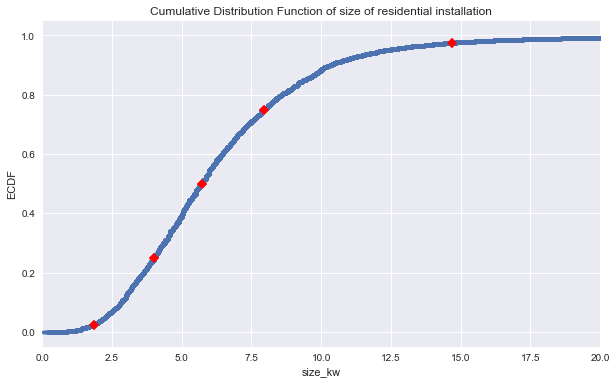

In [47]:
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles = np.percentile(xx, percentiles)
plt.plot(ptiles, percentiles/100, marker='D', color='red', linestyle='none')

plt.xlim((0, 20))
plt.plot(xx, yy, marker='.', linestyle='none')
plt.xlabel('size_kw')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution Function of size of residential installation');
plt.plot(ptiles, percentiles/100, marker='D', color='red', linestyle='none')